In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os 
os.chdir('/content/drive/MyDrive/Alzheimer dataset')
print('We are inside the folder', os.getcwd())

We are inside the folder /content/drive/MyDrive/Alzheimer dataset


In [ ]:
data= '/content/drive/MyDrive/Alzheimer dataset/'

In [ ]:
train_path= data + "//train"
os.listdir(train_path)

['NonDemented', 'VeryMildDemented', 'ModerateDemented', 'MildDemented']

In [ ]:
test_path= data + "//test"
os.listdir(test_path)

['ModerateDemented', 'VeryMildDemented', 'NonDemented', 'MildDemented']

In [ ]:
print("No. of images in NonDemented:", len(os.listdir(train_path+ '//NonDemented')))
print("No. of images in MildDemented:", len(os.listdir(train_path+ '//MildDemented')))
print("No. of images in VeryMildDemented:", len(os.listdir(train_path+ '//VeryMildDemented')))
print("No. of images in ModerateDemented:", len(os.listdir(train_path+ '//ModerateDemented')))

No. of images in NonDemented: 2560
No. of images in MildDemented: 717
No. of images in VeryMildDemented: 1792
No. of images in ModerateDemented: 52


In [ ]:
print("No. of images in NonDemented:", len(os.listdir(test_path+ '//NonDemented')))
print("No. of images in MildDemented:", len(os.listdir(test_path+ '//MildDemented')))
print("No. of images in VeryMildDemented:", len(os.listdir(test_path+ '//VeryMildDemented')))
print("No. of images in ModerateDemented:", len(os.listdir(test_path+ '//ModerateDemented')))

No. of images in NonDemented: 640
No. of images in MildDemented: 179
No. of images in VeryMildDemented: 448
No. of images in ModerateDemented: 12


In [ ]:
data_dir= '/content/drive/MyDrive/Alzheimer dataset/train'
os.listdir(data_dir)


['NonDemented', 'VeryMildDemented', 'ModerateDemented', 'MildDemented']

In [ ]:
classes = ['NonDemented', 'MildDemented', 'VeryMildDemented', 'ModerateDemented']

IMG_SIZE= 176
IMAGE_SIZE= [176, 176]
DIM= (IMG_SIZE, IMG_SIZE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Performing Image Augmentation

ZOOM= [.99, 1.01]
BRIGHT_RANGE= [0.8, 1.2]
HORZ_FLIP= True
FILL_MODE= 'constant'
DATA_FORMAT= 'channels_last'

work_dr= ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, 
                            zoom_range=ZOOM, data_format=DATA_FORMAT, 
                            fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)


train_data_gen = work_dr.flow_from_directory(directory=data_dir, target_size=DIM, batch_size=5200, shuffle=False)

Found 5121 images belonging to 4 classes.


In [ ]:
#Retrieving the data from the ImageDataGenerator iterator

'''
The next function returns a batch from the dataset. 
The return value of next function is in form of (x_train, y_train) where x_train is training features and y_train, its labels
'''

train_data, train_labels = train_data_gen.next()

In [ ]:
#Getting shape of dataset

print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced
sm= SMOTE(random_state=42)
train_data, train_labels= sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE* 3), train_labels)

train_data= train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
print("Size of Train data: ", len(train_data))
print("Size of Test data: ", len(test_data))
print("Size of Val data: ", len(val_data), '\n')
print("Size of Train Labels: ", len(train_labels))
print("Size of Test Labels: ", len(test_labels))
print("Size of Val Labels: ", len(val_labels))

Size of Train data:  6553
Size of Test data:  2048
Size of Val data:  1639 

Size of Train Labels:  6553
Size of Test Labels:  2048
Size of Val Labels:  1639


Model Building 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt



from PIL import Image
from random import randint

import tensorflow.keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

InceptionV3 Transfer learning model 

In [ ]:
model = InceptionV3(input_shape=(176,176,3), include_top= False, weights="imagenet")

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
#Turning off the traning layers

for layer in model.layers:
  layer.trainable= False

In [ ]:
custom_model= Sequential([
                          model,
                          Dropout(0.5),
                          GlobalAveragePooling2D(),
                          Flatten(),
                          BatchNormalization(),
                          Dense(512, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(256, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(128, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(64, activation='relu'),
                          Dropout(0.5),
                          BatchNormalization(),
                          Dense(4, activation='softmax')], name= "custom_model")

In [ ]:
custom_model.summary()

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)              

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoc, logs={}):
    if logs.get('Accuracy')>0.99:
      print("\n Reached accuracy...Stopped Traning")
      self.model.stop_training= True

my_callback= MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback= ReduceLROnPlateau(moniter= "val_loss", patience=3)



In [ ]:
#pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
METRICS= [tf.keras.metrics.CategoricalAccuracy(name= 'Accuracy'),
          tf.keras.metrics.AUC(name= 'AUC'),
          tfa.metrics.F1Score(num_classes=4)]

CALLBACKS= [my_callback, rop_callback]

In [ ]:
#Compile the model 

custom_model.compile(optimizer= 'adam', loss= tf.losses.CategoricalCrossentropy(), metrics= METRICS)

In [ ]:
#Model Training 
EPOCHS = 75
history= custom_model.fit(train_data,
                          train_labels, 
                          validation_data= (val_data, val_labels), 
                          callbacks= CALLBACKS, 
                          epochs= EPOCHS)

Epoch 1/75
205/205 [==============================] - 10s 51ms/step - loss: 0.2110 - Accuracy: 0.9234 - AUC: 0.9912 - f1_score: 0.9232 - val_loss: 0.3126 - val_Accuracy: 0.8768 - val_AUC: 0.9828 - val_f1_score: 0.8762 - lr: 1.0000e-07
Epoch 2/75
205/205 [==============================] - 10s 49ms/step - loss: 0.2132 - Accuracy: 0.9242 - AUC: 0.9910 - f1_score: 0.9241 - val_loss: 0.3119 - val_Accuracy: 0.8774 - val_AUC: 0.9828 - val_f1_score: 0.8769 - lr: 1.0000e-07
Epoch 3/75
205/205 [==============================] - 10s 49ms/step - loss: 0.2269 - Accuracy: 0.9168 - AUC: 0.9901 - f1_score: 0.9167 - val_loss: 0.3126 - val_Accuracy: 0.8761 - val_AUC: 0.9828 - val_f1_score: 0.8756 - lr: 1.0000e-07
Epoch 4/75
205/205 [==============================] - 10s 49ms/step - loss: 0.2255 - Accuracy: 0.9202 - AUC: 0.9900 - f1_score: 0.9201 - val_loss: 0.3121 - val_Accuracy: 0.8780 - val_AUC: 0.9828 - val_f1_score: 0.8777 - lr: 1.0000e-07
Epoch 5/75
205/205 [==============================] - 10s 49

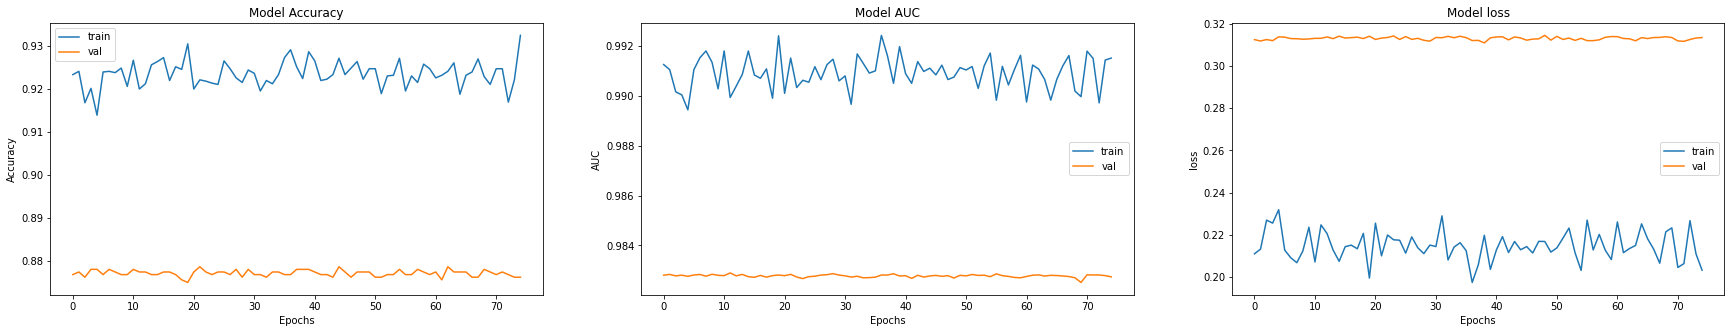

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["Accuracy", "AUC", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

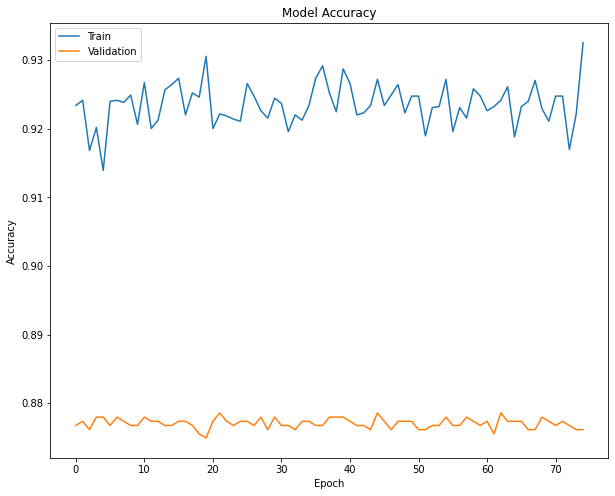

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
#Evaluating the model on the data

test_scores = custom_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100), '\n')

train_scores = custom_model.evaluate(train_data, train_labels)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100), '\n')

val_scores = custom_model.evaluate(val_data, val_labels)
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100), '\n')

64/64 [==============================] - 4s 39ms/step - loss: 0.3175 - Accuracy: 0.8779 - AUC: 0.9826 - f1_score: 0.8767
Testing Accuracy: 87.79% 

205/205 [==============================] - 8s 38ms/step - loss: 0.0471 - Accuracy: 0.9910 - AUC: 0.9999 - f1_score: 0.9910
Training Accuracy: 99.10% 

52/52 [==============================] - 2s 38ms/step - loss: 0.3135 - Accuracy: 0.8761 - AUC: 0.9827 - f1_score: 0.8756
Validation Accuracy: 87.61% 



In [ ]:
#Predicting the test data

pred_labels = custom_model.predict(test_data)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

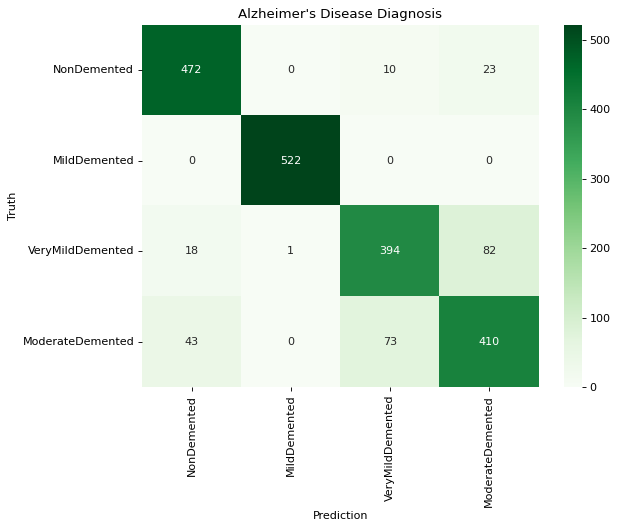

In [ ]:
#Plotting confusion matrix

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_mtx= confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_mtx, cmap='Greens', annot=True, fmt='d', xticklabels= classes,
                yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
#model.save("Alzmr_inptn_model.h5")

In [ ]:
custom_model_dir= data + "Alzmr_inptnV3_train_model"
custom_model.save(custom_model_dir, save_format='h5')
os.listdir(data)

['train',
 'test',
 'dataset',
 '.ipynb_checkpoints',
 'Alzmr_inptnV3_model',
 'Alzmr_inptnV3_train_model']

In [ ]:
# Load the  model
from keras.models import load_model
model = load_model('Alzmr_inptnV3_train_model')

In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100), '\n')

train_scores = model.evaluate(train_data, train_labels)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100), '\n')

val_scores = model.evaluate(val_data, val_labels)
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100),'\n')

64/64 [==============================] - 4s 38ms/step - loss: 0.3175 - Accuracy: 0.8779 - AUC: 0.9826 - f1_score: 0.8767
Testing Accuracy: 87.79% 

205/205 [==============================] - 9s 39ms/step - loss: 0.0471 - Accuracy: 0.9910 - AUC: 0.9999 - f1_score: 0.9910
Training Accuracy: 99.10% 

52/52 [==============================] - 2s 39ms/step - loss: 0.3135 - Accuracy: 0.8761 - AUC: 0.9827 - f1_score: 0.8756
Validation Accuracy: 87.61% 

